In [ ]:
!pip install mlflow

     |████████████████████████████████| 14.6 MB 2.0 MB/s 
     |████████████████████████████████| 79 kB 7.4 MB/s 
     |████████████████████████████████| 1.1 MB 52.0 MB/s 
     |████████████████████████████████| 56 kB 3.2 MB/s 
  Created wheel for alembic: filename=alembic-1.4.1-py2.py3-none-any.whl size=158172 sha256=96bb9fdad1a9d6249ddb8367b7cc10ce8488e62dabd4196ddb28beab604e316c
  Stored in directory: /root/.cache/pip/wheels/be/5d/0a/9e13f53f4f5dfb67cd8d245bb7cdffe12f135846f491a283e3
  Created wheel for databricks-cli: filename=databricks_cli-0.15.0-py3-none-any.whl size=105260 sha256=92aea4ee57f30aa544cea50f9b0c9e7367fd8677607a7375bfb6820de63451ba
  Stored in directory: /root/.cache/pip/wheels/e7/ba/75/284f9a90ff7a010bb23b9798f2e9a19dd9fe619379c917bff4
  Created wheel for prometheus-flask-exporter: filename=prometheus_flask_exporter-0.18.2-py3-none-any.whl size=17415 sha256=b85d5b22d932becf60ab577a35376a1f816bb9fa0fcfedb06162672c675a7e37
  Stored in directory: /root/.cache/pip/whee

In [ ]:
import os
import cv2
import numpy as np
import pandas as pd
import seaborn as sns
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

import torch
import torch.nn as nn
import torchvision
from torchvision import models
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader

from dataset import *
from train import *
from utils import *

import mlflow
import mlflow.pytorch

In [ ]:
mlflow.autolog ()

2021/09/28 12:39:51 INFO mlflow.tracking.fluent: Autologging successfully enabled for statsmodels.


### prepairing labels

In [ ]:
labels = pd.read_csv('../input/rsna-512x512-png/data/train_labels.csv')
columns = ['patientId', 'Target']

labels = labels.filter(columns)
labels.head(3)

,patientId,Target
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,0
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,0
2,00322d4d-1c29-4943-afc9-b6754be640eb,0


In [ ]:
len (labels)

30227

In [ ]:
train_lbls, valid_lbls, test_lbls = shuffle_split (labels, seed = 3)
print ('train size: ', len (train_lbls))
print ('valid size: ', len (valid_lbls))
print ('test size: ', len (test_lbls))

train size:  24183
valid size:  3022
test size:  3022


In [ ]:
train_lbls [:4]

array([['327e22ca-95fb-4c16-8314-827e535694ac', 0],
       ['36c3ea72-267d-4eb7-a0b2-a3e34acd2d07', 1],
       ['8f96a6fe-81f4-4b69-a2f2-8477b9ea9772', 1],
       ['e925f4f9-e253-4805-8662-583382f74280', 0]], dtype=object)

### prepairing images

In [ ]:
img_dir = '../input/rsna-512x512-png/data/stage_2_train_images'

train_paths = [os.path.join(img_dir, image[0]) for image in train_lbls]
valid_paths = [os.path.join(img_dir, image[0]) for image in valid_lbls]
test_paths = [os.path.join(img_dir, image[0]) for image in test_lbls]

print (len (train_paths))
print (len (valid_paths))
print (len (test_paths))

24183
3022
3022


In [ ]:
train_paths [:3]

['../input/rsna-512x512-png/data/stage_2_train_images/327e22ca-95fb-4c16-8314-827e535694ac',
 '../input/rsna-512x512-png/data/stage_2_train_images/36c3ea72-267d-4eb7-a0b2-a3e34acd2d07',
 '../input/rsna-512x512-png/data/stage_2_train_images/8f96a6fe-81f4-4b69-a2f2-8477b9ea9772']

Visualize data

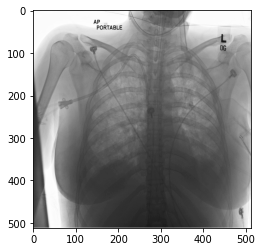

In [ ]:
idx = np.random.choice (len (train_paths))
img = plt.imread (train_paths [idx] + '.png')
plt.imshow (img, cmap=plt.cm.binary)

### prepairing custum dataset

In [ ]:
train_tfms = transforms.Compose([
    #transforms.RandomRotation ((-20, 20)),
    transforms.RandomHorizontalFlip (),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize (mean = [0.485, 0.456, 0.406], 
                          std = [0.229, 0.224, 0.225])
])

valid_tfms =  transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize (mean = [0.485, 0.456, 0.406], 
                          std = [0.229, 0.224, 0.225])
])


In [ ]:
train_ds = RSNADataset (train_paths, train_lbls, transform = train_tfms)
valid_ds = RSNADataset (valid_paths, valid_lbls, transform = valid_tfms)
test_ds = RSNADataset (test_paths, test_lbls, transform = valid_tfms)

visualize dataset

torch.Size([3, 224, 224])
0


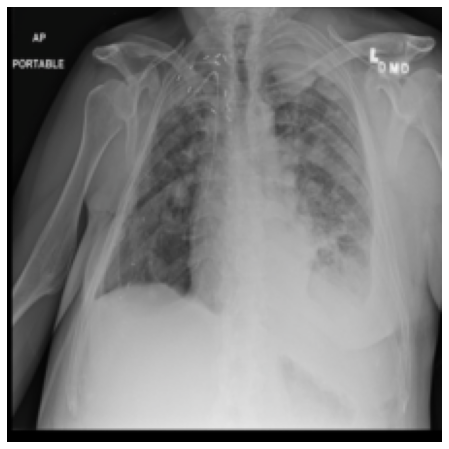

In [ ]:
idx = np.random.choice (len (train_ds))
img, lbl = train_ds [idx]
print (img.shape)
print (lbl)
imshow (img)

In [ ]:
train_dl = DataLoader (train_ds, batch_size = 128, shuffle = True)
valid_dl = DataLoader (valid_ds, batch_size = 128, shuffle = False)
test_dl = DataLoader (test_ds, batch_size = 32, shuffle = False)

<Figure size 720x720 with 0 Axes>

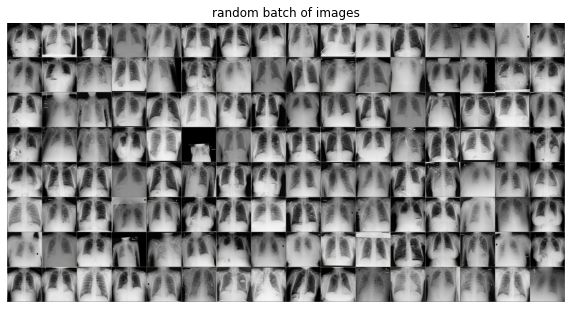

In [ ]:
img, lbl = next (iter (train_dl))
plt.figure (figsize = (10, 10))
img = torchvision.utils.make_grid (img, nrow = 16)
imshow (img, 'random batch of images')

In [ ]:
device = torch.device ('cuda' if torch.cuda.is_available() else 'cpu')

# Training

## ResNet50

In [ ]:
model = models.resnet50 (pretrained = True)
num_features = model.fc.in_features

model.fc = nn.Linear(num_features, 2)

In [ ]:
model.to(device)

loss_fn = nn.CrossEntropyLoss()
loss_fn.to(device)

optimizer = torch.optim.Adam (model.parameters(), lr = 0.0002)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau (optimizer, factor = 0.1, patience = 2)

checkpoint_path = 'ResNet50.pth'

In [ ]:
history = fit (model, train_dl, valid_dl, loss_fn, optimizer, 5, accuracy, device, checkpoint_path, scheduler)

=> saving checkpoint
Epoch [1/5], loss: 0.5066 - acc: 0.7528 - val_loss: 0.6249 - val_acc: 0.7147
=> saving checkpoint
Epoch [2/5], loss: 0.4641 - acc: 0.7833 - val_loss: 0.4640 - val_acc: 0.7821
=> saving checkpoint
Epoch [3/5], loss: 0.4509 - acc: 0.7883 - val_loss: 0.4375 - val_acc: 0.7949
Epoch [4/5], loss: 0.4353 - acc: 0.7956 - val_loss: 0.4642 - val_acc: 0.7808
=> saving checkpoint
Epoch [5/5], loss: 0.4051 - acc: 0.8129 - val_loss: 0.4185 - val_acc: 0.8081
Training complete in 30m 18s


plot results

In [ ]:
loss = history ['loss']
val_loss = history ['val_loss']
acc = history ['acc']
val_acc = history ['val_acc']

Text(0.5, 1.0, 'accuracy')

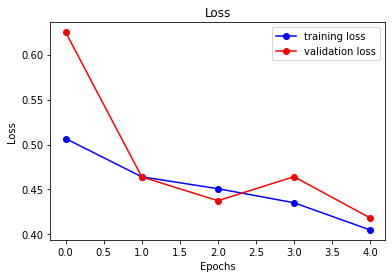

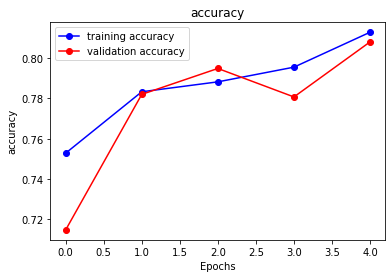

In [ ]:
plot_acc_loss (loss, val_loss, acc, val_acc)

testing

In [ ]:
# testing on train and valid set
load_checkpoint (torch.load (checkpoint_path), model)
evaluate (model, test_dl, loss_fn, accuracy, device)

=> loading checkpoint


(0.41154227005807975, 0.813345864661654)

In [ ]:
y_test, y_pred = [], []
for imgs, lbls in test_dl:
    imgs = imgs.to(device)
    outs = model (imgs)
    _, preds = torch.max (outs, dim = 1)
    y_test += lbls.tolist ()
    y_pred += preds.tolist ()
print ('done!')

done!


2021/09/28 13:11:39 INFO mlflow.tracking.fluent: Autologging successfully enabled for sklearn.


<AxesSubplot:title={'center':'Confusion Matrix'}>

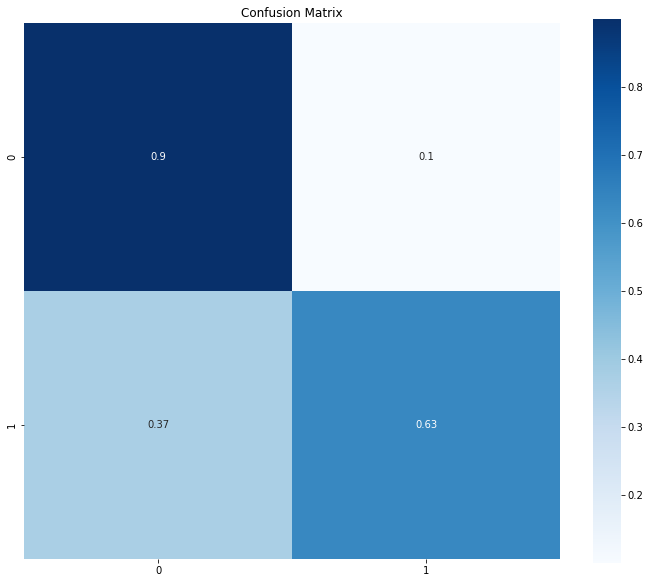

In [ ]:
cm = confusion_matrix (y_test, y_pred, normalize = 'true')
cm_df = pd.DataFrame (cm)
plt.figure (figsize = (12, 10))
plt.title ('Confusion Matrix')
sns.heatmap (cm_df, annot = True, cmap = 'Blues', square = True)

In [ ]:
print (classification_report (y_test, y_pred))

              precision    recall  f1-score   support

           0       0.84      0.90      0.87      2066
           1       0.74      0.63      0.68       956

    accuracy                           0.81      3022
   macro avg       0.79      0.77      0.78      3022
weighted avg       0.81      0.81      0.81      3022



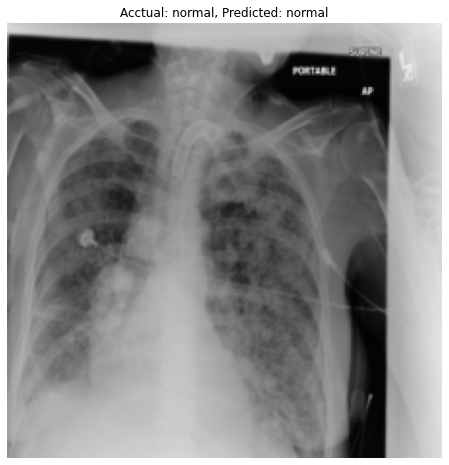

In [ ]:
predict_image (model, test_dl, device)

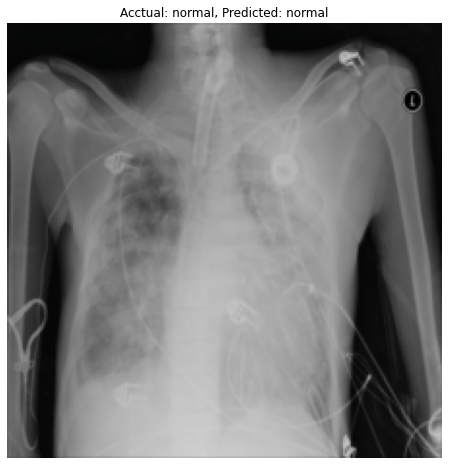

In [ ]:
predict_image (model, test_dl, device)

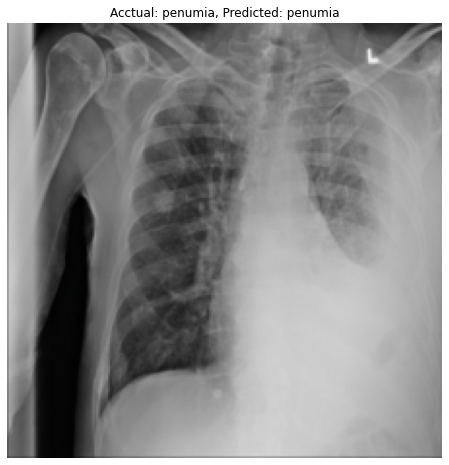

In [ ]:
predict_image (model, test_dl, device)

## MobileNetV2

In [ ]:
model = models.mobilenet_v2 (pretrained = True)

Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth


  0%|          | 0.00/13.6M [00:00<?, ?B/s]

In [ ]:
for param in model.parameters():
    param.requires_grad = False

model.classifier = nn.Sequential(
    nn.Dropout (0.2),
    nn.Linear (1280, 2)
)

In [ ]:
model.to(device)

loss_fn = nn.CrossEntropyLoss()
loss_fn.to(device)

optimizer = torch.optim.Adam (model.parameters(), lr = 0.0002)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau (optimizer, factor = 0.1, patience = 2)

checkpoint_path = 'MobileNetV2.pth'

In [ ]:
history = fit (model, train_dl, valid_dl, loss_fn, optimizer, 10, accuracy, device, checkpoint_path, scheduler)

=> saving checkpoint
Epoch [1/10], loss: 0.4971 - acc: 0.7476 - val_loss: 0.4635 - val_acc: 0.7902
Epoch [2/10], loss: 0.4604 - acc: 0.7758 - val_loss: 0.4589 - val_acc: 0.7811
=> saving checkpoint
Epoch [3/10], loss: 0.4498 - acc: 0.7853 - val_loss: 0.4452 - val_acc: 0.7957
=> saving checkpoint
Epoch [4/10], loss: 0.4463 - acc: 0.7838 - val_loss: 0.4421 - val_acc: 0.7971
Epoch [5/10], loss: 0.4436 - acc: 0.7872 - val_loss: 0.4452 - val_acc: 0.7895
=> saving checkpoint
Epoch [6/10], loss: 0.4421 - acc: 0.7892 - val_loss: 0.4400 - val_acc: 0.8024
Epoch [7/10], loss: 0.4421 - acc: 0.7916 - val_loss: 0.4395 - val_acc: 0.7981
Epoch [8/10], loss: 0.4416 - acc: 0.7902 - val_loss: 0.4403 - val_acc: 0.7972
Epoch [9/10], loss: 0.4389 - acc: 0.7898 - val_loss: 0.4397 - val_acc: 0.7959
Epoch [10/10], loss: 0.4413 - acc: 0.7889 - val_loss: 0.4393 - val_acc: 0.7995
Training complete in 42m 10s


In [ ]:
for param in model.parameters():
    param.requires_grad = True
    
optimizer = torch.optim.Adam (model.parameters(), lr = 0.0001)
checkpoint_path = 'MobileNetV2(1).pth'

In [ ]:
history1 = fit (model, train_dl, valid_dl, loss_fn, optimizer, 5, accuracy, device, checkpoint_path, scheduler)

=> saving checkpoint
Epoch [1/5], loss: 0.3986 - acc: 0.8159 - val_loss: 0.3693 - val_acc: 0.8295
=> saving checkpoint
Epoch [2/5], loss: 0.3491 - acc: 0.8403 - val_loss: 0.3611 - val_acc: 0.8345
Epoch [3/5], loss: 0.3134 - acc: 0.8630 - val_loss: 0.3735 - val_acc: 0.8294
=> saving checkpoint
Epoch [4/5], loss: 0.2701 - acc: 0.8872 - val_loss: 0.3796 - val_acc: 0.8370
=> saving checkpoint
Epoch [5/5], loss: 0.2187 - acc: 0.9118 - val_loss: 0.4285 - val_acc: 0.8399
Training complete in 28m 3s


plot results

In [ ]:
loss = history ['loss'] + history1 ['loss']
val_loss = history ['val_loss'] + history1 ['val_loss']
acc = history ['acc'] + history1 ['acc']
val_acc = history ['val_acc'] + history1 ['val_acc']

Text(0.5, 1.0, 'accuracy')

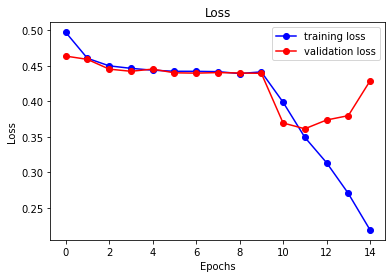

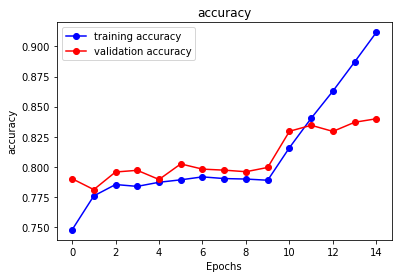

In [ ]:
plot_acc_loss (loss, val_loss, acc, val_acc)

In [ ]:
# testing on train and valid set
load_checkpoint (torch.load (checkpoint_path), model)
evaluate (model, test_dl, loss_fn, accuracy, device)

=> loading checkpoint


(0.4465559306897615, 0.8345864661654135)

In [ ]:
y_test, y_pred = [], []
for imgs, lbls in test_dl:
    imgs = imgs.to(device)
    outs = model (imgs)
    _, preds = torch.max (outs, dim = 1)
    y_test += lbls.tolist ()
    y_pred += preds.tolist ()
print ('done!')

done!


<AxesSubplot:title={'center':'Confusion Matrix'}>

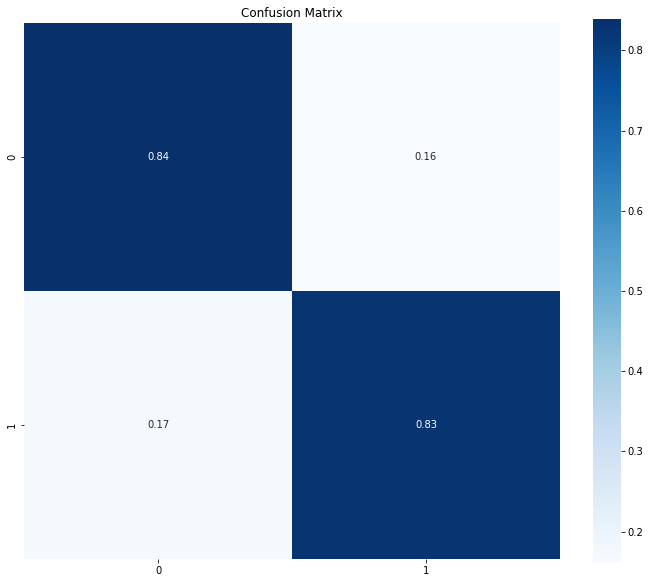

In [ ]:
cm = confusion_matrix (y_test, y_pred, normalize = 'true')
cm_df = pd.DataFrame (cm)
plt.figure (figsize = (12, 10))
plt.title ('Confusion Matrix')
sns.heatmap (cm_df, annot = True, cmap = 'Blues', square = True)

In [ ]:
print (classification_report (y_test, y_pred))

              precision    recall  f1-score   support

           0       0.91      0.84      0.87      2066
           1       0.70      0.83      0.76       956

    accuracy                           0.83      3022
   macro avg       0.81      0.83      0.82      3022
weighted avg       0.85      0.83      0.84      3022



## DenseNet201

In [ ]:
train_dl = DataLoader (train_ds, batch_size = 32, shuffle = True)
valid_dl = DataLoader (valid_ds, batch_size = 32, shuffle = False)
test_dl = DataLoader (test_ds, batch_size = 32, shuffle = False)

In [ ]:
model = models.densenet201 (pretrained = True)

In [ ]:
for param in model.parameters():
    param.requires_grad = False

in_features = model.classifier.in_features
model.classifier = nn.Sequential(
    nn.Linear(in_features, 2)
)

In [ ]:
model.to(device)

loss_fn = nn.CrossEntropyLoss()
loss_fn.to(device)

optimizer = torch.optim.Adam (model.parameters(), lr = 0.0002)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau (optimizer, factor = 0.1, patience = 2)

checkpoint_path = 'DenseNet201.pth'

In [ ]:
history = fit (model, train_dl, valid_dl, loss_fn, optimizer, 10, accuracy, device, checkpoint_path, scheduler)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


=> saving checkpoint
Epoch [1/10], loss: 0.5076 - acc: 0.7459 - val_loss: 0.4682 - val_acc: 0.7833
=> saving checkpoint
Epoch [2/10], loss: 0.4467 - acc: 0.7911 - val_loss: 0.4497 - val_acc: 0.7895
=> saving checkpoint
Epoch [3/10], loss: 0.4341 - acc: 0.7978 - val_loss: 0.4485 - val_acc: 0.7940
=> saving checkpoint
Epoch [4/10], loss: 0.4291 - acc: 0.8002 - val_loss: 0.4370 - val_acc: 0.7983
Epoch [5/10], loss: 0.4241 - acc: 0.8033 - val_loss: 0.4366 - val_acc: 0.7976
=> saving checkpoint
Epoch [6/10], loss: 0.4239 - acc: 0.8021 - val_loss: 0.4369 - val_acc: 0.8002
Epoch [7/10], loss: 0.4229 - acc: 0.8051 - val_loss: 0.4356 - val_acc: 0.7992
Epoch [8/10], loss: 0.4228 - acc: 0.8026 - val_loss: 0.4361 - val_acc: 0.7973
Epoch [9/10], loss: 0.4234 - acc: 0.8033 - val_loss: 0.4357 - val_acc: 0.7989
Epoch [10/10], loss: 0.4228 - acc: 0.8038 - val_loss: 0.4361 - val_acc: 0.7996
Training complete in 80m 12s


In [ ]:
load_checkpoint (torch.load (checkpoint_path), model)

=> loading checkpoint


In [ ]:
for param in model.parameters():
    param.requires_grad = True
    
optimizer = torch.optim.Adam (model.parameters(), lr = 0.0001)
checkpoint_path = 'DenseNet201(1).pth'

In [ ]:
history1 = fit (model, train_dl, valid_dl, loss_fn, optimizer, 5, accuracy, device, checkpoint_path, scheduler)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


=> saving checkpoint
Epoch [1/5], loss: 0.4004 - acc: 0.8164 - val_loss: 0.3698 - val_acc: 0.8237
=> saving checkpoint
Epoch [2/5], loss: 0.3595 - acc: 0.8371 - val_loss: 0.3599 - val_acc: 0.8375
Epoch [3/5], loss: 0.3276 - acc: 0.8540 - val_loss: 0.3878 - val_acc: 0.8218
=> saving checkpoint
Epoch [4/5], loss: 0.2990 - acc: 0.8708 - val_loss: 0.3800 - val_acc: 0.8435
Epoch [5/5], loss: 0.2562 - acc: 0.8914 - val_loss: 0.3628 - val_acc: 0.8431
Training complete in 99m 44s


In [ ]:
checkpoint = {'state_dict': model.state_dict (), 'optimizer': optimizer.state_dict ()}
save_checkpoint (checkpoint, checkpoint_path)

=> saving checkpoint


plot results

In [ ]:
loss = history1 ['loss'] 
val_loss = history1 ['val_loss']
acc = history1 ['acc']
val_acc = history1 ['val_acc']

Text(0.5, 1.0, 'accuracy')

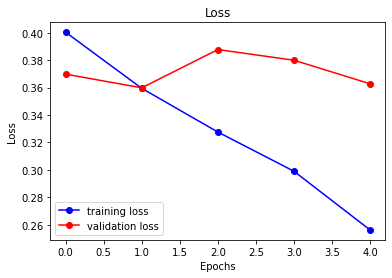

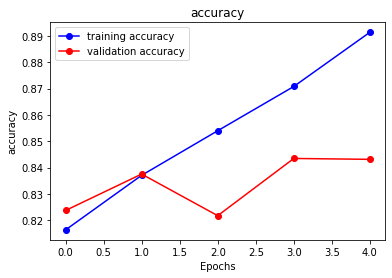

In [ ]:
plot_acc_loss (loss, val_loss, acc, val_acc)

In [ ]:
# testing on train and test set
load_checkpoint (torch.load (checkpoint_path), model)
evaluate (model, test_dl, loss_fn, accuracy, device)

=> loading checkpoint


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


(0.35000329268606084, 0.8485432330827067)

85% on test set